## Gerçek Veri ile Sonuçlar

Bu kısımda gerçek veri seti ile modellerin performansları değerlendirilmektedir.
11 tane oltalama, 11 tane güvenli olmak üzere 22 örnekli bir veri seti kullanılmıştır. Veri seti GPT-4o modeli ile oluşturulmuştur.


In [3]:
import pandas as pd

df_test = pd.read_excel("../source/real-test-set.xlsx")
df_test.head()

,text,label
0,"Hello John,\n\nIt was a pleasure meeting you a...",0
1,"Hi Team,\n\nJust a quick reminder about our ma...",0
2,"Dear Sarah,\n\nWelcome to the Customer Support...",0
3,"Hello Clara,\n\nThank you for your recent purc...",0
4,"Dear Team,\n\nGiven our recent discussion on m...",0


In [4]:
import os
models_dir = os.path.join(os.path.dirname(os.getcwd()), "source", "models")

In [5]:
import pandas as pd
import joblib
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model


def load_model_and_vectorizer(model_path, vectorizer_path):
    """Model ve vektörleştiriciyi yükler"""
    try:
        # .h5 uzantılı dosyalar için Keras load_model kullan
        if model_path.endswith('.h5'):
            model = load_model(model_path)
        else:
            model = joblib.load(model_path)
            
        vectorizer = joblib.load(vectorizer_path)
       
            
        return model, vectorizer
    except Exception as e:
        print(f"Model yüklenirken hata: {e}")
        return None, None
    

In [6]:
import tensorflow as tf

def make_predictions(model, vectorizer, texts):
    """Metinler için tahmin yapar"""
    vectors = vectorizer.transform(texts)
    if isinstance(model, tf.keras.Model):
        vectors = vectors.toarray()
        predictions = model.predict(vectors)
        predictions = (predictions > 0.5).astype(int)
    else:
        predictions = model.predict(vectors)
    return predictions

In [7]:
import re
import unicodedata

# Şapkalı harfleri ve diğer diakritik işaretleri temizleme
def remove_diacritics(text):
    # Normalizasyon formu kullanarak diakritik işaretleri ayrıştır
    text = unicodedata.normalize('NFD', text)
    # Diakritik işaretleri olmayan harfleri bırakarak yeni bir string oluştur
    return ''.join([char for char in text if not unicodedata.combining(char)])


def clean_text(text):
    # Belirlenen karakterler dışındaki karakterler kaldırılır
    clean_text = remove_diacritics(text).lower()
    allowed_chars = re.compile(r'[^a-zA-Z0-9 *#$&/(){}[\]<>+=\-_\'^@.,;:!?"%\\|`~]')
    return allowed_chars.sub('', clean_text)


In [8]:
def evaluate_model_with_real_data(model, vectorizer, df_test, model_type, normalize=False):
    if normalize:
        texts = df_test["text"].apply(clean_text)
    else:
        texts = df_test["text"]
    labels = df_test["label"]
    
    """Gerçek veri seti ile modelin performansını değerlendirir"""
    predictions = make_predictions(model, vectorizer, texts)  # Değişiklik burada
    accuracy = accuracy_score(labels, predictions)
    report = classification_report(labels, predictions)
    conf_matrix = confusion_matrix(labels, predictions)
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Güvenli', 'Oltalama'],
                yticklabels=['Güvenli', 'Oltalama'])
    plt.title(f'{model_type} Test Seti Confusion Matrix')
    plt.xlabel('Tahmin')
    plt.ylabel('Gerçek')
    plt.show()

    # Yanlış tahminleri göster
    print("\nYanlış Tahmin Edilen E-postalar:")
    for i, (pred, true) in enumerate(zip(predictions, df_test['label'])):
        if pred != true:
            print(f"\nE-posta {i + 1}:")
            print(f"Metin: {df_test.iloc[i]['text'][:200]}...")
            print(f"Tahmin: {'Oltalama' if pred == 1 else 'Güvenli'}")
            print(f"Gerçek: {'Oltalama' if true == 1 else 'Güvenli'}")
            print("-" * 80)
    return accuracy, report, conf_matrix

### SVM Modelinin Değerlendirilmesi

Sonuçlar aşağıda gösterilmektedir.

| Model | Veri Seti | Doğruluk |
|-------|-----------|-----------|
| SVM | Ham | 0.8182 |
| SVM | Filtrelenmiş | 0.8636 |
| SVM | Temizlenmiş | 0.8182 |

En iyi model SVM Filtrelenmiş Veri ile SVM Modeli (Doğruluk: 0.8636)

In [16]:
svm_dir = os.path.join(models_dir, "svm")
svm_models = {"raw": os.path.join(svm_dir, "raw", "raw_data_svm.joblib"),
              "filtered": os.path.join(svm_dir, "filtered", "filtered_data_svm.joblib"),
              "cleaned": os.path.join(svm_dir, "cleaned", "cleaned_data_svm.joblib"),
              }
svm_vectorizers = {"raw": os.path.join(svm_dir, "raw", "raw_data_tfidf.joblib"),
              "filtered": os.path.join(svm_dir, "filtered", "filtered_data_tfidf.joblib"),
              "cleaned": os.path.join(svm_dir, "cleaned", "cleaned_data_tfidf.joblib"),
              }


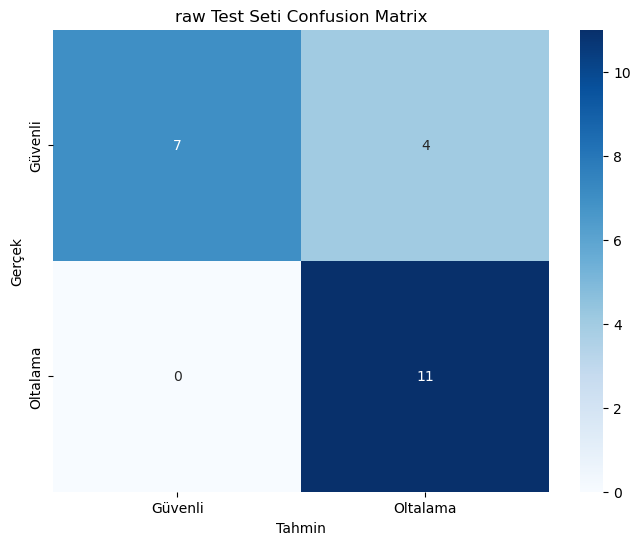


Yanlış Tahmin Edilen E-postalar:

E-posta 3:
Metin: Dear Sarah,

Welcome to the Customer Support team at Widget Corp! We are thrilled to have you on board and look forward to seeing the contributions you will make.

Your first week will be primarily or...
Tahmin: Oltalama
Gerçek: Güvenli
--------------------------------------------------------------------------------

E-posta 4:
Metin: Hello Clara,

Thank you for your recent purchase of the Deluxe Coffee Maker from our store. We hope it is brewing up delightful mornings for you!

Could you spare a few moments to provide feedback on ...
Tahmin: Oltalama
Gerçek: Güvenli
--------------------------------------------------------------------------------

E-posta 8:
Metin: Subject: Upcoming Team Outing – Save the Date!

From: Marcus Reynolds marcus.reynolds@designsolutions.com

To: Design Team design.team@designsolutions.com

Date: October 20, 2022

Dear Team,

I am exc...
Tahmin: Oltalama
Gerçek: Güvenli
------------------------------------

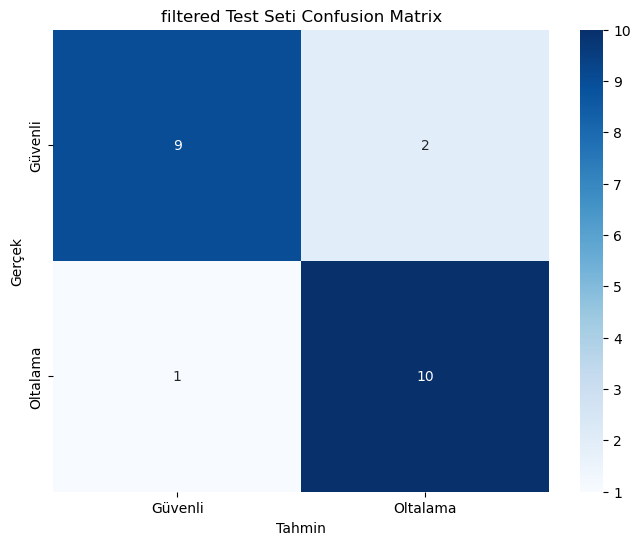


Yanlış Tahmin Edilen E-postalar:

E-posta 4:
Metin: Hello Clara,

Thank you for your recent purchase of the Deluxe Coffee Maker from our store. We hope it is brewing up delightful mornings for you!

Could you spare a few moments to provide feedback on ...
Tahmin: Oltalama
Gerçek: Güvenli
--------------------------------------------------------------------------------

E-posta 10:
Metin: Subject: Exciting News: Launching Our New Eco-Friendly Product Line!

From: Rachel Green rachel.green@ecoproducts.com

To: EcoProducts Subscribers subscriber.list@ecoproducts.com

Date: December 27, 2...
Tahmin: Oltalama
Gerçek: Güvenli
--------------------------------------------------------------------------------

E-posta 14:
Metin: Dear Valued Customer,

Our records indicate that you have an outstanding invoice that has not been paid. Please settle this invoice as soon as possible to avoid penalties.

Invoice Number: 456123 Amou...
Tahmin: Güvenli
Gerçek: Oltalama
----------------------------------

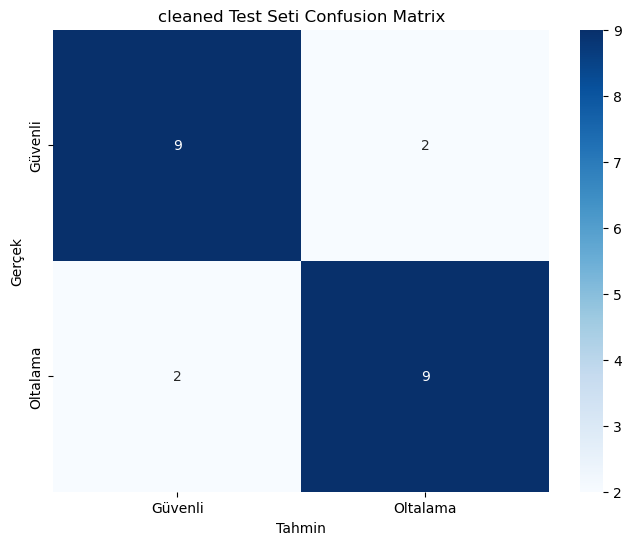


Yanlış Tahmin Edilen E-postalar:

E-posta 4:
Metin: Hello Clara,

Thank you for your recent purchase of the Deluxe Coffee Maker from our store. We hope it is brewing up delightful mornings for you!

Could you spare a few moments to provide feedback on ...
Tahmin: Oltalama
Gerçek: Güvenli
--------------------------------------------------------------------------------

E-posta 10:
Metin: Subject: Exciting News: Launching Our New Eco-Friendly Product Line!

From: Rachel Green rachel.green@ecoproducts.com

To: EcoProducts Subscribers subscriber.list@ecoproducts.com

Date: December 27, 2...
Tahmin: Oltalama
Gerçek: Güvenli
--------------------------------------------------------------------------------

E-posta 14:
Metin: Dear Valued Customer,

Our records indicate that you have an outstanding invoice that has not been paid. Please settle this invoice as soon as possible to avoid penalties.

Invoice Number: 456123 Amou...
Tahmin: Güvenli
Gerçek: Oltalama
----------------------------------

In [20]:
model_results = {}

for model_name, model_path in svm_models.items():
    model, vectorizer = load_model_and_vectorizer(model_path, svm_vectorizers[model_name])
    
    if model_name == "cleaned":
        accuracy, report, conf_matrix = evaluate_model_with_real_data(model, vectorizer, df_test, model_name, normalize=True)
    else:
        accuracy, report, conf_matrix = evaluate_model_with_real_data(model, vectorizer, df_test, model_name, normalize=False)
    
    model_results[model_name] = accuracy

print("\nGerçek Veri Seti Üzerinde Model Performansları:")
print("-" * 50)
for model_name, accuracy in model_results.items():
    print(f"{model_name.capitalize()} Veri ile SVM Modeli Doğruluk: {accuracy:.4f}")

best_model = max(model_results.items(), key=lambda x: x[1])
print("\nEn İyi Model:")
print(f"{best_model[0].capitalize()} Veri ile SVM Modeli (Doğruluk: {best_model[1]:.4f})")

## SVM-Cross Validation Sonuçları

| Veri Seti | Model | Gerçek Veri Doğruluk |
|-----------|-------|----------------------|
| Ham | SVM | 0.8182 |
| Filtrelenmiş | SVM | 0.8636 |
| Temizlenmiş | SVM | 0.8182 |

En iyi model SVM Filtrelenmiş Veri ile SVM Modeli (Doğruluk: 0.8636)

In [24]:
svm_cv_dir = os.path.join(models_dir, "svm-cv")
svm_cv_models = {"raw": os.path.join(svm_cv_dir, "raw-cv5", "raw_data_svm.joblib"),
              "filtered": os.path.join(svm_cv_dir, "filtered-cv5", "filtered_data_svm.joblib"),
              "cleaned": os.path.join(svm_cv_dir, "cleaned-cv5", "cleaned_data_svm.joblib"),
              }
svm_cv_vectorizers = {"raw": os.path.join(svm_cv_dir, "raw-cv5", "raw_data_tfidf.joblib"),
              "filtered": os.path.join(svm_cv_dir, "filtered-cv5", "filtered_data_tfidf.joblib"),
              "cleaned": os.path.join(svm_cv_dir, "cleaned-cv5", "cleaned_data_tfidf.joblib"),
              }


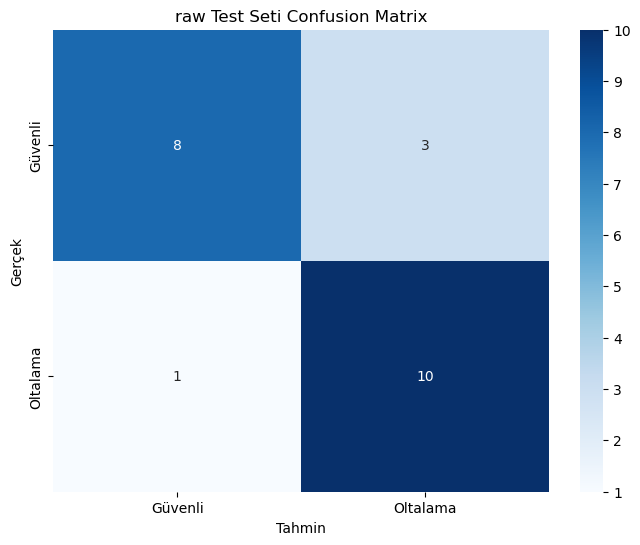


Yanlış Tahmin Edilen E-postalar:

E-posta 3:
Metin: Dear Sarah,

Welcome to the Customer Support team at Widget Corp! We are thrilled to have you on board and look forward to seeing the contributions you will make.

Your first week will be primarily or...
Tahmin: Oltalama
Gerçek: Güvenli
--------------------------------------------------------------------------------

E-posta 4:
Metin: Hello Clara,

Thank you for your recent purchase of the Deluxe Coffee Maker from our store. We hope it is brewing up delightful mornings for you!

Could you spare a few moments to provide feedback on ...
Tahmin: Oltalama
Gerçek: Güvenli
--------------------------------------------------------------------------------

E-posta 10:
Metin: Subject: Exciting News: Launching Our New Eco-Friendly Product Line!

From: Rachel Green rachel.green@ecoproducts.com

To: EcoProducts Subscribers subscriber.list@ecoproducts.com

Date: December 27, 2...
Tahmin: Oltalama
Gerçek: Güvenli
-----------------------------------

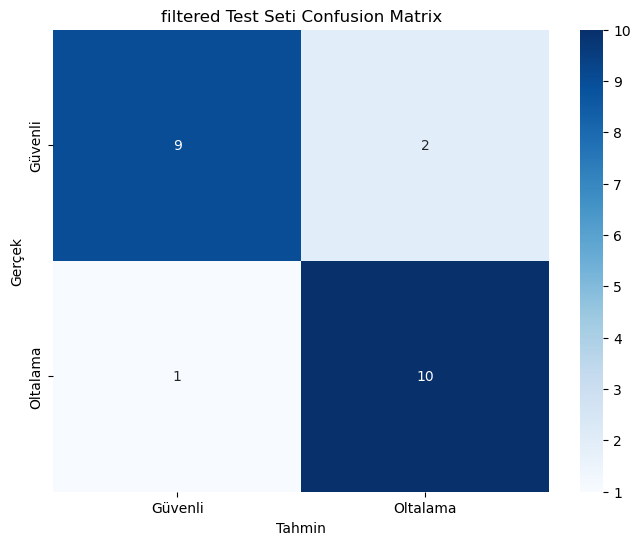


Yanlış Tahmin Edilen E-postalar:

E-posta 4:
Metin: Hello Clara,

Thank you for your recent purchase of the Deluxe Coffee Maker from our store. We hope it is brewing up delightful mornings for you!

Could you spare a few moments to provide feedback on ...
Tahmin: Oltalama
Gerçek: Güvenli
--------------------------------------------------------------------------------

E-posta 10:
Metin: Subject: Exciting News: Launching Our New Eco-Friendly Product Line!

From: Rachel Green rachel.green@ecoproducts.com

To: EcoProducts Subscribers subscriber.list@ecoproducts.com

Date: December 27, 2...
Tahmin: Oltalama
Gerçek: Güvenli
--------------------------------------------------------------------------------

E-posta 14:
Metin: Dear Valued Customer,

Our records indicate that you have an outstanding invoice that has not been paid. Please settle this invoice as soon as possible to avoid penalties.

Invoice Number: 456123 Amou...
Tahmin: Güvenli
Gerçek: Oltalama
----------------------------------

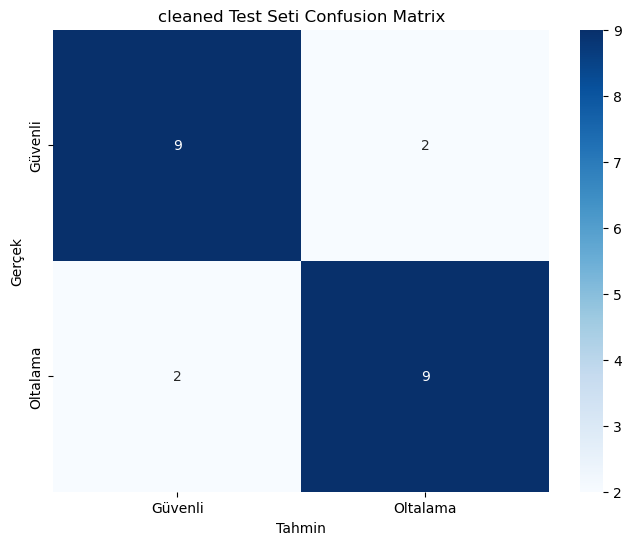


Yanlış Tahmin Edilen E-postalar:

E-posta 4:
Metin: Hello Clara,

Thank you for your recent purchase of the Deluxe Coffee Maker from our store. We hope it is brewing up delightful mornings for you!

Could you spare a few moments to provide feedback on ...
Tahmin: Oltalama
Gerçek: Güvenli
--------------------------------------------------------------------------------

E-posta 10:
Metin: Subject: Exciting News: Launching Our New Eco-Friendly Product Line!

From: Rachel Green rachel.green@ecoproducts.com

To: EcoProducts Subscribers subscriber.list@ecoproducts.com

Date: December 27, 2...
Tahmin: Oltalama
Gerçek: Güvenli
--------------------------------------------------------------------------------

E-posta 14:
Metin: Dear Valued Customer,

Our records indicate that you have an outstanding invoice that has not been paid. Please settle this invoice as soon as possible to avoid penalties.

Invoice Number: 456123 Amou...
Tahmin: Güvenli
Gerçek: Oltalama
----------------------------------

In [25]:
model_results = {}

for model_name, model_path in svm_cv_models.items():
    model, vectorizer = load_model_and_vectorizer(model_path, svm_cv_vectorizers[model_name])
    
    if model_name == "cleaned":
        accuracy, report, conf_matrix = evaluate_model_with_real_data(model, vectorizer, df_test, model_name, normalize=True)
    else:
        accuracy, report, conf_matrix = evaluate_model_with_real_data(model, vectorizer, df_test, model_name, normalize=False)
    
    model_results[model_name] = accuracy

print("\nGerçek Veri Seti Üzerinde Model Performansları:")
print("-" * 50)
for model_name, accuracy in model_results.items():
    print(f"{model_name.capitalize()} Veri ile SVM Modeli Doğruluk: {accuracy:.4f}")

best_model = max(model_results.items(), key=lambda x: x[1])
print("\nEn İyi Model:")
print(f"{best_model[0].capitalize()} Veri ile SVM Modeli (Doğruluk: {best_model[1]:.4f})")

### MLP Modelinin Değerlendirilmesi

Filtrelenmiş Veri ile MLP Modeli Doğruluk:  0.7273


    

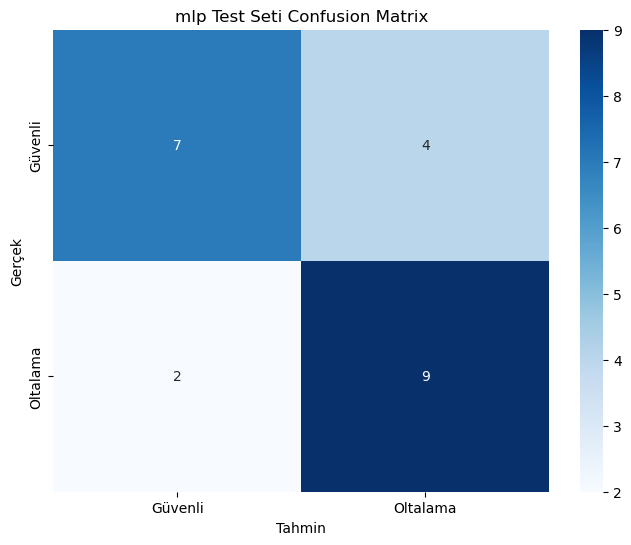


Yanlış Tahmin Edilen E-postalar:

E-posta 2:
Metin: Hi Team,

Just a quick reminder about our marketing strategy meeting scheduled for tomorrow:

Time: 10:00 AM
Location: Conference Room B
Agenda: Finalize Q2 campaign priorities and budgets
Please revi...
Tahmin: Oltalama
Gerçek: Güvenli
--------------------------------------------------------------------------------

E-posta 4:
Metin: Hello Clara,

Thank you for your recent purchase of the Deluxe Coffee Maker from our store. We hope it is brewing up delightful mornings for you!

Could you spare a few moments to provide feedback on ...
Tahmin: Oltalama
Gerçek: Güvenli
--------------------------------------------------------------------------------

E-posta 8:
Metin: Subject: Upcoming Team Outing – Save the Date!

From: Marcus Reynolds marcus.reynolds@designsolutions.com

To: Design Team design.team@designsolutions.com

Date: October 20, 2022

Dear Team,

I am exc...
Tahmin: Oltalama
Gerçek: Güvenli
------------------------------------

In [28]:
mlp_dir = os.path.join(models_dir, "mlp")
mlp_models = {"mlp": os.path.join(mlp_dir, "filtered_mlp.joblib")}
mlp_vectorizers = {"mlp": os.path.join(mlp_dir, "filtered_tfidf.joblib")}

model, vectorizer = load_model_and_vectorizer(mlp_models["mlp"], mlp_vectorizers["mlp"])

accuracy, report, conf_matrix = evaluate_model_with_real_data(model, vectorizer, df_test, "mlp", normalize=False)

print(f"Accuracy: {accuracy:.4f}")


### Logistic Regression Modelinin Değerlendirilmesi

Filtrelenmiş Veri ile Logistic Regression Modeli Doğruluk:  0.7727



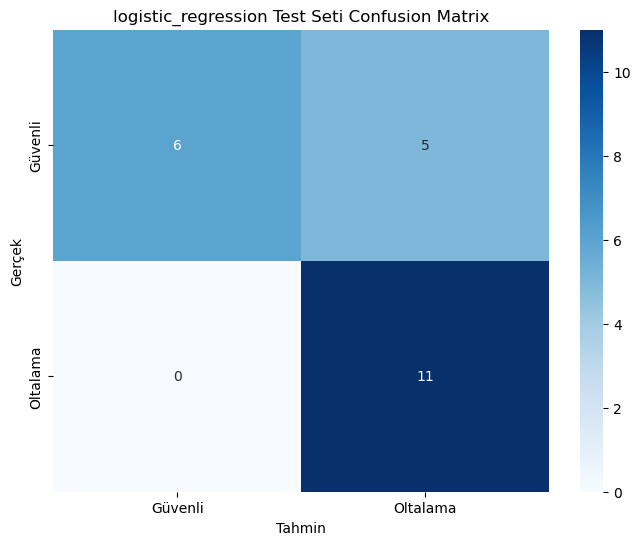


Yanlış Tahmin Edilen E-postalar:

E-posta 3:
Metin: Dear Sarah,

Welcome to the Customer Support team at Widget Corp! We are thrilled to have you on board and look forward to seeing the contributions you will make.

Your first week will be primarily or...
Tahmin: Oltalama
Gerçek: Güvenli
--------------------------------------------------------------------------------

E-posta 4:
Metin: Hello Clara,

Thank you for your recent purchase of the Deluxe Coffee Maker from our store. We hope it is brewing up delightful mornings for you!

Could you spare a few moments to provide feedback on ...
Tahmin: Oltalama
Gerçek: Güvenli
--------------------------------------------------------------------------------

E-posta 5:
Metin: Dear Team,

Given our recent discussion on market expansion and customer acquisition, I propose an increase in our marketing budget by 20% for the upcoming fiscal year. This increase will support enha...
Tahmin: Oltalama
Gerçek: Güvenli
------------------------------------

In [29]:
lr_dir = os.path.join(models_dir, "logistic_regression")


model, vectorizer = load_model_and_vectorizer(os.path.join(lr_dir, "filtered_logistic.joblib"),
                                              os.path.join(lr_dir, "filtered_tfidf.joblib"))

accuracy, report, conf_matrix = evaluate_model_with_real_data(model, vectorizer, df_test, 
                                                              "logistic_regression", normalize=False)

print(f"Accuracy: {accuracy:.4f}")


### DNN Modelinin Değerlendirilmesi

Filtrelenmiş Veri ile DNN Modeli Doğruluk:  0.7273




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


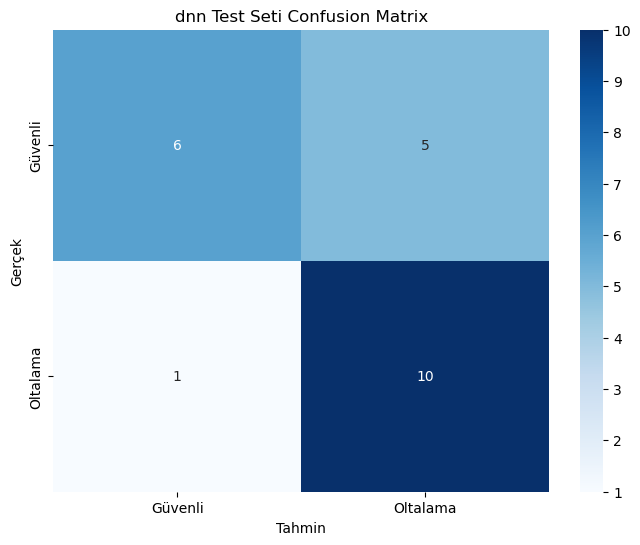


Yanlış Tahmin Edilen E-postalar:

E-posta 1:
Metin: Hello John,

It was a pleasure meeting you at the Annual Business Conference last week. I really enjoyed our conversation about the innovative ways technology is transforming industry workflows, espec...
Tahmin: Oltalama
Gerçek: Güvenli
--------------------------------------------------------------------------------

E-posta 2:
Metin: Hi Team,

Just a quick reminder about our marketing strategy meeting scheduled for tomorrow:

Time: 10:00 AM
Location: Conference Room B
Agenda: Finalize Q2 campaign priorities and budgets
Please revi...
Tahmin: Oltalama
Gerçek: Güvenli
--------------------------------------------------------------------------------

E-posta 3:
Metin: Dear Sarah,

Welcome to the Customer Support team at Widget Corp! We are thrilled to have you on board and look forward to seeing the contributions you will make.

Your first week will be primarily or...
Tahmin: Oltalama
Gerçek: Güvenli
------------------------------------

In [10]:
dnn_dir = os.path.join(models_dir, "dnn")

model, vectorizer = load_model_and_vectorizer(os.path.join(dnn_dir, "filtered_dnn.h5"),
                                            os.path.join(dnn_dir, "filtered_tfidf.joblib"))

accuracy, report, conf_matrix = evaluate_model_with_real_data(model, vectorizer, df_test, 
                                                            "dnn", normalize=False)

print(f"Accuracy: {accuracy:.4f}")